In [152]:
#import YouTube_Data_Story as ds
import YouTube_Data_Wrangling as dw
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import stats
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import holidays
import datetime
from datetime import date
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, VotingClassifier
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve

from sklearn.feature_extraction.text import CountVectorizer
import nltk
from collections import Counter
import matplotlib
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [156]:
## FUNCTIONS

def prec_re(y_test, y_pred, classifier):
    ps,rs,fs,ss=precision_recall_fscore_support(y_test, y_pred, average=None,labels=[0,1,2])
    df=pd.DataFrame({'precision': ps, 'recall': rs, 'f-score': fs, 'sample_size': ss})
    return df.style.set_caption("Precision-Recall -"+ classifier).\
        format({'precision': "{:.2}", 'recall': "{:.2}", 'f-score': "{:.2}" })

def feature_importance(estimator, ax, title):
    
    feat_importances = pd.Series(estimator.feature_importances_, index=X.columns)
    feat_importances.nlargest(20).plot(kind='barh', ax=ax, title=title)
    plt.title(title)
    
def confusion(y_test, y_pred,title):
    ax = plt.axes()
    cm=confusion_matrix(y_test, y_pred,  labels=[0, 1, 2], normalize='all')
    df = pd.DataFrame(cm*100, range(3), range(3))
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df, annot=True, annot_kws={"size": 16}) # font size
    ax.set_title(title)
    plt.show()
    

In [2]:
usa_df=pd.read_csv("USvideos.csv", parse_dates=[5])
mx_df=pd.read_csv("MXvideos.csv",engine='python')
usa_df['category_name']=usa_df['category_id'].map(dw.category_usa)
mx_df['category_name']=mx_df['category_id'].map(dw.category_mx)

usa_df['country']='USA'
mx_df['country']='Mexico'

df_combined_usa_mx=usa_df.append(mx_df)
df_combined_usa_mx.reset_index(inplace=True, drop=True)
df_combined_usa_mx.drop_duplicates(inplace=True)
df_combined_usa_mx.dropna(axis=0, how="any",inplace=True)
df_combined_usa_mx.reset_index(inplace=True, drop=True)

In [3]:
#df_combined_usa_mx.head()

In [5]:
#publish_time - breaking into year/month/day/weekday/time columns

df_combined_usa_mx['publish_time'] = pd.to_datetime(df_combined_usa_mx['publish_time'], utc=True)
df_combined_usa_mx['p_year']=df_combined_usa_mx['publish_time'].dt.year
df_combined_usa_mx['p_month'] =df_combined_usa_mx['publish_time'].dt.month
df_combined_usa_mx['p_day'] = df_combined_usa_mx['publish_time'].dt.day
df_combined_usa_mx["p_weekday"]=df_combined_usa_mx['publish_time'].dt.weekday
df_combined_usa_mx['p_time'] = df_combined_usa_mx['publish_time'].dt.hour

In [110]:
#Changing trending_date to datetime object
def tempdate(a):
    b=a.split(".")
    c=b[1]+b[2]+b[0]
    return c

df_combined_usa_mx['trending_date_new']=df_combined_usa_mx['trending_date'].apply(tempdate)
df_combined_usa_mx['trending_date_new']=pd.to_datetime(df_combined_usa_mx['trending_date_new'])
df_combined_usa_mx['trending_date']=df_combined_usa_mx['trending_date_new']
df_combined_usa_mx.drop(['trending_date_new'],axis=1,inplace=True)
df_combined_usa_mx['trending_date']=pd.to_datetime(df_combined_usa_mx['trending_date'])
#combined_usa_mx_df.info()
#Both dateTime columns have been converted to dateTime type successfully
###

In [8]:
#df_combined_usa_mx.info() #7635 entries

In [9]:
df=df_combined_usa_mx.sort_values('trending_date', ascending=False).groupby('title').first()
df.reset_index(inplace=True)

In [11]:
#df.info() #35843 entries

In [12]:
df['title_len']=df.title.str.len()
df['channel_title_len']=df.channel_title.str.len()

In [13]:
#disabled CC rows are dropped as they unnessarly give smaller Engagemnt score 
rowstodel=df[df.comments_disabled==True].index
df.drop(rowstodel, inplace=True)


#disabled ratings rows are dropped as they unnessarly give smaller Engagemnt score 
rowstodel1=df[df.ratings_disabled==True].index
df.drop(rowstodel1, inplace=True)


In [14]:
df.reset_index(inplace=True, drop=True)

In [16]:
#df.info()  #35152(cc and ratings disabled)

In [17]:
# Not adding ER as (likes/dislikes/2*cc) as when I take it's log it's almost 100% 0.0 which makes no difference. 
#I am going to take CC_log, likes_log, dislikes_log

df['En']=df.likes+df.dislikes+2*df.comment_count

In [18]:
df_save=df #saved df 

df_catname_cat=pd.DataFrame({'cat':df.category_id,'cat_name':df.category_name})  #saving catname and cat mapping

In [19]:
#df.columns  #Index(['title', 'video_id', 'trending_date', 'channel_title', 'category_id','publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       #'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       #'video_error_or_removed', 'description', 'category_name', 'country',
       #'p_year', 'p_month', 'p_day', 'p_weekday', 'p_time', 'title_len',
       #'channel_title_len', 'ER'],
      #dtype='object')

In [20]:
df['views_log']=np.log(df.views)
df['En_log']=np.log((df.En+1))

In [21]:
df.drop(['channel_title','description','tags','trending_date','category_name','publish_time','likes','dislikes','comment_count','views','En','video_id','thumbnail_link', 'comments_disabled', 'ratings_disabled','video_error_or_removed' ], axis=1, inplace=True)

In [22]:
#### DO TEXT ANALYSIS NOW

In [23]:
text_data=np.array(df['title'])
len(text_data)

35152

In [24]:
count = CountVectorizer()
bag_of_words = count.fit_transform(text_data)

In [25]:
feature_names = count.get_feature_names()
len(feature_names)

35122

In [26]:
df_nlp=pd.DataFrame(bag_of_words.toarray(), columns=feature_names)

In [27]:
stopwordsE = nltk.corpus.stopwords.words('english')
stopwordsS = nltk.corpus.stopwords.words('spanish')

# RegEx for stopwords
RE_stopwordsE = r'\b(?:{})\b'.format('|'.join(stopwordsE))
RE_stopwordsS = r'\b(?:{})\b'.format('|'.join(stopwordsS))

# replace '|'-->' ' and drop all stopwords
words = (df.title
           .str.lower()
           .replace([r'\d+|', r'\|',r'-|',r'&|',RE_stopwordsE,RE_stopwordsS,'\(', '\'', '\)', '\//',':', '/',',','#','!'], ['','','','','','','','','','','','','','',''], regex=True)
           .str.cat(sep=' ')
           .split()
)

# generate DataFrame out of Counter
rslt = pd.DataFrame(Counter(words).most_common(11),
                    columns=['Word', 'Frequency']).set_index('Word')
rslt.index

Index(['vs', 'video', 'parte', 'completo', 'capitulo', 'hd', 'programa',
       'capã­tulo', 'hoy', 'official', 'vivo'],
      dtype='object', name='Word')

In [29]:
word_list=['vs', 'video', 'parte', 'completo', 'capitulo', 'hd', 'programa', 'hoy', 'official', 'vivo']
df_nlp_new=df_nlp[word_list]
#df_nlp_new.info() #35152 entries

In [30]:
#df.info()
df1=pd.concat([df,df_nlp_new], axis=1)
#df1.head()

,title,category_id,country,p_year,p_month,p_day,p_weekday,p_time,title_len,channel_title_len,...,vs,video,parte,completo,capitulo,hd,programa,hoy,official,vivo
0,Es admirable que Shani haya tenido agallas pa...,17,Mexico,2018,2,1,3,19,68,18,...,0,0,0,0,0,0,0,0,0,0
1,"Fantasma, no necesitabas traer a tus achichin...",17,Mexico,2018,3,8,3,20,75,18,...,0,0,0,0,0,0,0,0,0,0
2,Me La JuguÃ© con Riesgo a Tronarme AsÃ­ HablÃ...,17,Mexico,2018,5,6,6,6,99,13,...,0,0,0,0,0,0,0,0,0,0
3,PEDRO INFANTE ERA CHAPARRITO - ISMAEL RODR...,10,Mexico,2018,3,27,1,12,51,10,...,0,0,0,0,0,0,0,0,0,0
4,SI SOY PEDRO INFANTE - ANTONIO PEDRO A TERE...,10,Mexico,2017,12,1,4,14,58,10,...,0,0,0,0,0,0,0,0,0,0


In [31]:
df1.drop(['title'], axis=1, inplace=True)

In [32]:
df1.head()

,category_id,country,p_year,p_month,p_day,p_weekday,p_time,title_len,channel_title_len,views_log,...,vs,video,parte,completo,capitulo,hd,programa,hoy,official,vivo
0,17,Mexico,2018,2,1,3,19,68,18,8.7,...,0,0,0,0,0,0,0,0,0,0
1,17,Mexico,2018,3,8,3,20,75,18,8.6,...,0,0,0,0,0,0,0,0,0,0
2,17,Mexico,2018,5,6,6,6,99,13,9.2,...,0,0,0,0,0,0,0,0,0,0
3,10,Mexico,2018,3,27,1,12,51,10,9.3,...,0,0,0,0,0,0,0,0,0,0
4,10,Mexico,2017,12,1,4,14,58,10,10.6,...,0,0,0,0,0,0,0,0,0,0


In [33]:
#Prepocessing : Changing country to 0 and 1 

In [34]:
enc = preprocessing.LabelEncoder()
enc = enc.fit(df1['country'])
df1['country'] = enc.transform(df1['country'])

In [35]:
df1.head()

,category_id,country,p_year,p_month,p_day,p_weekday,p_time,title_len,channel_title_len,views_log,...,vs,video,parte,completo,capitulo,hd,programa,hoy,official,vivo
0,17,0,2018,2,1,3,19,68,18,8.7,...,0,0,0,0,0,0,0,0,0,0
1,17,0,2018,3,8,3,20,75,18,8.6,...,0,0,0,0,0,0,0,0,0,0
2,17,0,2018,5,6,6,6,99,13,9.2,...,0,0,0,0,0,0,0,0,0,0
3,10,0,2018,3,27,1,12,51,10,9.3,...,0,0,0,0,0,0,0,0,0,0
4,10,0,2017,12,1,4,14,58,10,10.6,...,0,0,0,0,0,0,0,0,0,0


## Clustering#######

In [36]:
df_cluster=df1[['views_log','En_log']] # cluster with 2 features only 

In [37]:
#KMeans elbow method to check for optimal K
inertia = []
K = range(1,10)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_cluster)
    inertia.append(kmeans.inertia_)

Text(0.5, 1.0, 'The Elbow Method showing the optimal k')

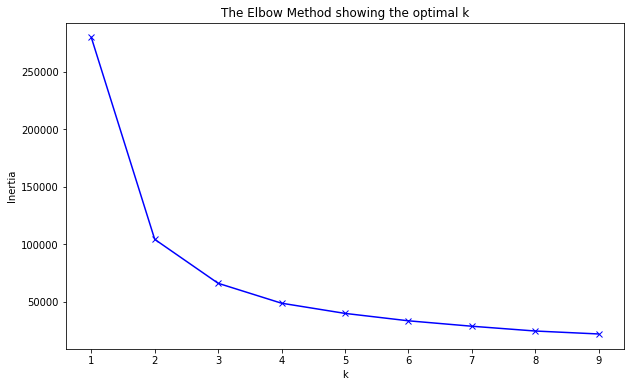

In [38]:
plt.figure(figsize=(10,6))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')

In [39]:
kmeans3= KMeans(n_clusters=3, random_state=0).fit(df_cluster)
pop_class3 = kmeans3.predict(df_cluster)
centers3 = kmeans3.cluster_centers_

#kmeans4 = KMeans(n_clusters=4, random_state=0).fit(df_cluster)
#pop_class4 = kmeans4.predict(df_cluster)
#centers4 = kmeans4.cluster_centers_

#kmeans5 = KMeans(n_clusters=5, random_state=0).fit(df_cluster)
#pop_class5 = kmeans5.predict(df_cluster)
#centers5 = kmeans5.cluster_centers_

In [40]:
df1['pop_class3']=pop_class3
#df['pop_class4']=pop_class4
#df['pop_class5']=pop_class5

#pop_class4 and 5 make the classes even more unbalanced. Delet pop_class4 and 5 later

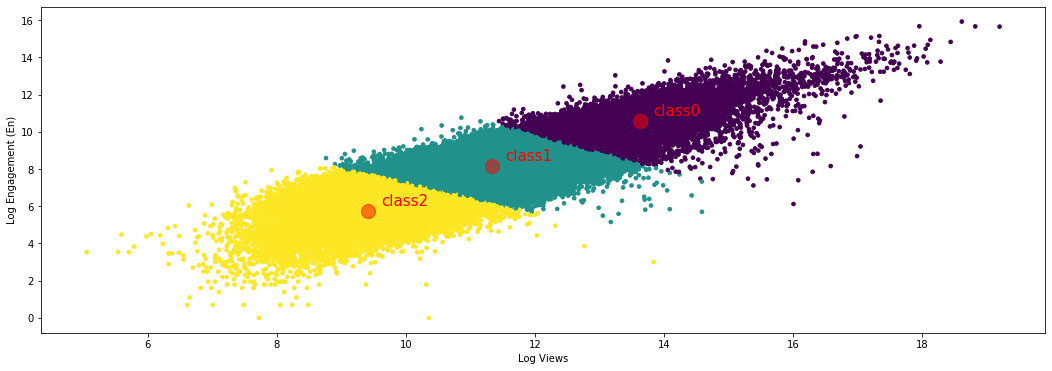

In [41]:
fig, ax = plt.subplots(figsize=(18,6))
ax.scatter(df1['views_log'],df1['En_log'], c=pop_class3, cmap='viridis', s=13)
ax.scatter(centers3[:, 0], centers3[:, 1], c='red', s=200, alpha=0.5)
#plt.colorbar(sc)
plt.xlabel("Log Views")
plt.ylabel("Log Engagement (En)")


y=centers3[:,1]
x=centers3[:,0]
n = ['class0','class1', 'class2']

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i]+0.2, y[i]+0.3), fontsize=15, color='r')

In [172]:
class_distribution=pd.DataFrame(df1.groupby(['pop_class3'])['category_id'].count())
class_distribution

,category_id
pop_class3,
0,9077
1,13949
2,12126


1. class 0 - views from 1.2M (e14 = 1202604.2841648) and onwards
2. class 1 - views from 0.2M (e12 = 162754.791419) to under 1.2M 
3. class 2 - views under 0.2M 

1. class 0 - engagement Score (En)is with class 0 videos around 60K and onwards {likes/dislikes/2*cc (e11 = 59874.141715198)}
2. class 1 - engagement score (En) is within 2900 to under 60K (e8 = 2980.9579870417 to e11)
3. class 2 - engagement score (End is within 0 to less then 2900 

Commentary:
Majority of the videos are in class 1 as can be seen by above table i.e. most videos from 2017/2018 got views between (0.2M and 1.2M) and En between 2900 and 60K 


In [63]:
df1.drop(['views_log','En_log'], axis=1, inplace=True)

In [168]:
#df1.head()

### Classification  with imbalanced class data

In [66]:
import imblearn
from imblearn.over_sampling import SMOTE

In [67]:
X=df1.drop(['pop_class3'], axis=1)

In [68]:
y=df1['pop_class3']

In [69]:
# see the distributions of the classes before SMOTE (Synthetic Minority Oversampling Technique)
counter = Counter(y)
counter

Counter({2: 12126, 0: 9077, 1: 13949})

In [70]:
X_train,X_test, y_train, y_test =train_test_split(X,y, random_state=0)

In [71]:
# transform the dataset
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [72]:
# see the distributions of the classes after SMOTE
counter = Counter(y_train)
counter

Counter({0: 10453, 2: 10453, 1: 10453})

In [73]:
#X_train and y_train are ready for classification training

## KNN

In [74]:
param_grid={'n_neighbors': np.arange(1,50)}

knn=KNeighborsClassifier()

knn_cv=GridSearchCV(knn,param_grid)

knn_cv.fit(X_train, y_train)

y_pred_knn=knn_cv.predict(X_test)

In [75]:
knn_cv.best_score_, knn_cv.best_params_, knn_cv.best_estimator_

(0.5875544141073747, {'n_neighbors': 1}, KNeighborsClassifier(n_neighbors=1))

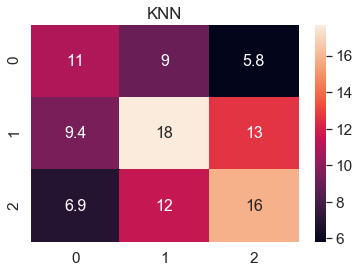

In [173]:
confusion(y_test, y_pred_knn, "KNN")

In [149]:
prec_re(y_test, y_pred_knn, 'KNN')

,precision,recall,f-score,sample_size
0,0.4,0.43,0.41,2267
1,0.46,0.44,0.45,3496
2,0.46,0.46,0.46,3025


## Random Forest

In [105]:
param_grid = [
    {
    'n_estimators' : list(range(10,101,10)),
    'max_features': list(range(4,8,2)), 
    'max_depth'    : [2, 3, 5, 10, 20],
    } 
]

RF=RandomForestClassifier()
RF_cv=GridSearchCV(RF, param_grid, cv=5)
RF_cv.fit(X_train, y_train)

y_pred_RF=RF_cv.predict(X_test)


In [106]:
RF_cv.best_score_, RF_cv.best_estimator_, RF_cv.best_params_

(0.6402948287631111,
 RandomForestClassifier(max_depth=20, max_features=6),
 {'max_depth': 20, 'max_features': 6, 'n_estimators': 100})

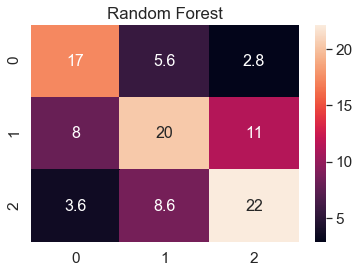

In [158]:
confusion(y_test, y_pred_RF, "Random Forest")

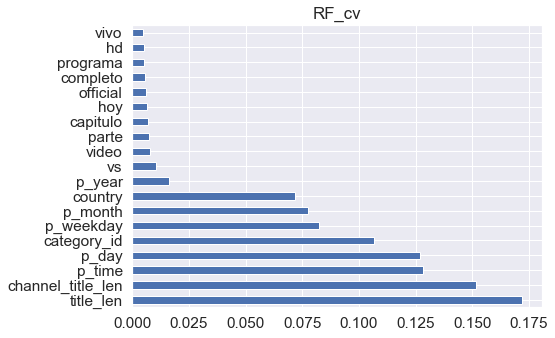

In [109]:
#Feature Importance (RF)
fig, axes=plt.subplots(1,1, figsize=(8,5))
feature_importance(RF_cv.best_estimator_, axes, 'RF_cv')
plt.tight_layout()

In [167]:
prec_re(y_test, y_pred_RF, 'Random Forest')

,precision,recall,f-score,sample_size
0,0.6,0.67,0.63,2267
1,0.59,0.51,0.55,3496
2,0.61,0.64,0.63,3025


### Notes on Precision/Recall/Fscore/SS

#Compute precision, recall, F-Score and support for each class

#Precision quantifies the number of positive class predictions that actually belong to the positive class. 
#Recall quantifies the number of positive class predictions made out of all positive examples in the dataset. 
#F-Score provides a single score that balances both the concerns of precision and recall in one number

#Precision talks about how precise/accurate your model is out of those predicted positive,how many of them are actual positive.

## Gradient Boost

In [95]:
param_grid=[{'n_estimators':list(range(20,100,10))}]
gb=GradientBoostingClassifier()

gb_cv=GridSearchCV(gb,param_grid)
gb_cv.fit(X_train, y_train)

y_pred_gb=gb_cv.predict(X_test)

In [175]:
gb_cv.best_score_, gb_cv.best_params_ 

(0.549602458189463, {'n_estimators': 90})

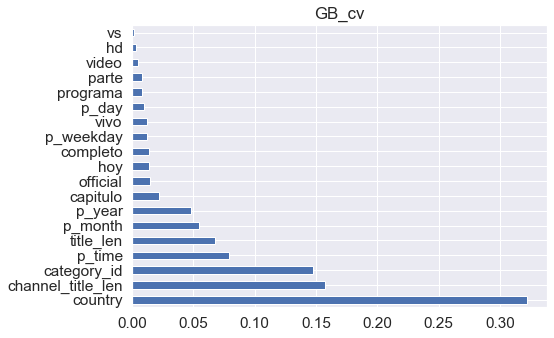

In [203]:
#Feature Importance (GB)
fig, axes=plt.subplots(1,1, figsize=(8,5))
feature_importance(gb_cv.best_estimator_, axes, 'GB_cv')
plt.tight_layout()

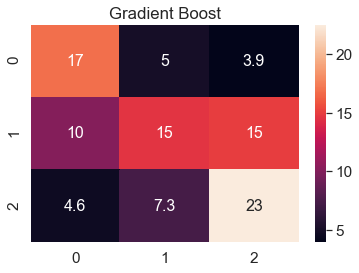

In [159]:
confusion(y_test, y_pred_gb, "Gradient Boost")

In [151]:
prec_re(y_test, y_pred_gb, 'Gradient Boost')

,precision,recall,f-score,sample_size
0,0.53,0.66,0.59,2267
1,0.54,0.37,0.44,3496
2,0.54,0.65,0.59,3025


# Accuracy_Scores:

In [177]:
my_dict={'KNN':'{:.2f}'.format(knn_cv.best_score_*100), 
         
         'RandomForest': '{:.2f}'.format(RF_cv.best_score_*100), 
         
         'Gradient Boosting': '{:.2f}'.format(gb_cv.best_score_*100),  
        }
score_df=pd.DataFrame(list(my_dict.items()),
                      columns=['Model','Best_Score'])
score_df.sort_values(by='Best_Score', ascending=False)

,Model,Best_Score
1,RandomForest,64.03
0,KNN,58.76
2,Gradient Boosting,54.96
